In [1]:
# Step 1: Import Libraries
import pandas as pd

# Step 2: Load the CSV files
df1 = pd.read_csv(r"C:\Users\HP\Desktop\Learnathon\Auto_Insurance_Fraud_Claims_File01.csv")
df2 = pd.read_csv(r"C:\Users\HP\Desktop\Learnathon\Auto_Insurance_Fraud_Claims_File02.csv")
df3 = pd.read_csv(r"C:\Users\HP\Desktop\Learnathon\Auto_Insurance_Fraud_Claims_File03.csv")

# Step 3: Align df3 (if it's missing one column)
missing_col = set(df1.columns).symmetric_difference(set(df3.columns))
for col in missing_col:
    df3[col] = pd.NA
df3 = df3[df1.columns]  # Reorder columns

# Step 4: Merge all files
df_all = pd.concat([df1, df2, df3], ignore_index=True)

# Step 5: Convert target column 'Fraud_Ind' to numeric
df_all['Fraud_Ind'] = df_all['Fraud_Ind'].map({'Y': 1, 'N': 0})

# Step 6: Drop rows where Fraud_Ind is missing (target is null)
df_all_cleaned = df_all.dropna(subset=['Fraud_Ind'])

# Step 7: Display cleaned dataset shape and top 10 missing columns
print("✅ Cleaned Dataset Shape:", df_all_cleaned.shape)
print("\n📌 Top Missing Columns:")
print(df_all_cleaned.isnull().sum().sort_values(ascending=False).head(10))

✅ Cleaned Dataset Shape: (60000, 53)

📌 Top Missing Columns:
Police_Report               20808
authorities_contacted        5605
Claim_ID                        0
Auto_Year                       0
Accident_Hour                   0
Num_of_Vehicles_Involved        0
Property_Damage                 0
Bodily_Injuries                 0
Witnesses                       0
DL_Expiry_Date                  0
dtype: int64


In [2]:
from sklearn.preprocessing import LabelEncoder

# Step 8.1: Drop irrelevant columns (like IDs or text-heavy fields)
df_all_cleaned = df_all_cleaned.drop(columns=['Claim_ID', 'Vehicle_Registration'])

# Step 8.2: Label Encode binary columns
binary_cols = ['Gender', 'Property_Damage', 'Police_Report', 'Check_Point']

le = LabelEncoder()
for col in binary_cols:
    if col in df_all_cleaned.columns:
        df_all_cleaned[col] = df_all_cleaned[col].astype(str)  # Ensure string
        df_all_cleaned[col] = le.fit_transform(df_all_cleaned[col])

# Step 8.3: One-Hot Encode other categorical features
df_all_encoded = pd.get_dummies(df_all_cleaned, drop_first=True)

# Step 8.4: Check final shape
print("✅ Final Encoded Dataset Shape:", df_all_encoded.shape)

✅ Final Encoded Dataset Shape: (60000, 1878)


In [3]:
# Step 1: Check for missing values
total_missing = df_all_encoded.isnull().sum().sum()
print("🧼 Total missing values in the dataset:", total_missing)

# Step 2: Drop columns with the same value across all rows
constant_cols = [col for col in df_all_encoded.columns if df_all_encoded[col].nunique() == 1]
print("🔻 Dropping constant columns:", constant_cols)
df_all_encoded.drop(columns=constant_cols, inplace=True)

# Step 3: Remove duplicate rows
duplicates = df_all_encoded.duplicated().sum()
print("🗑 Duplicate rows found:", duplicates)
df_all_encoded.drop_duplicates(inplace=True)

# Step 4: Final dataset summary
print("✅ Final dataset shape:", df_all_encoded.shape)
print("\n📊 Data type counts:")
print(df_all_encoded.dtypes.value_counts())

🧼 Total missing values in the dataset: 0
🔻 Dropping constant columns: ['Check_Point']
🗑 Duplicate rows found: 0
✅ Final dataset shape: (60000, 1877)

📊 Data type counts:
bool       1850
int64        17
float64       7
int32         3
Name: count, dtype: int64


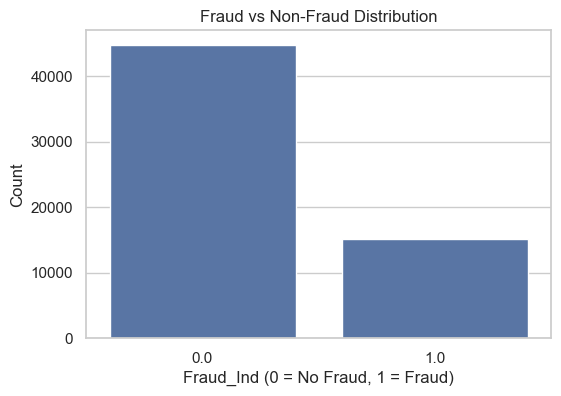

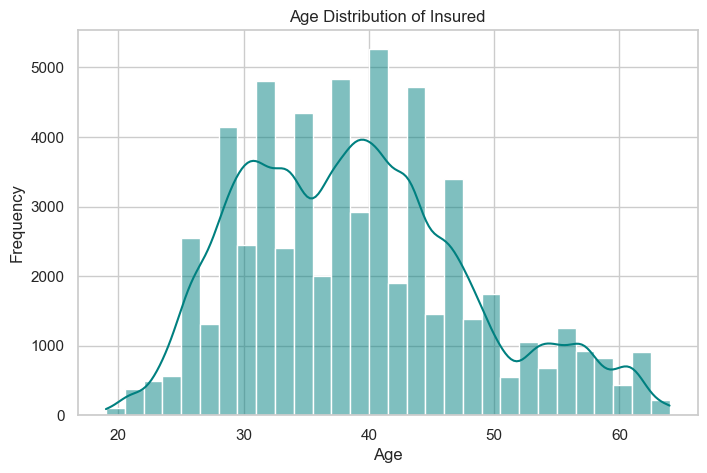

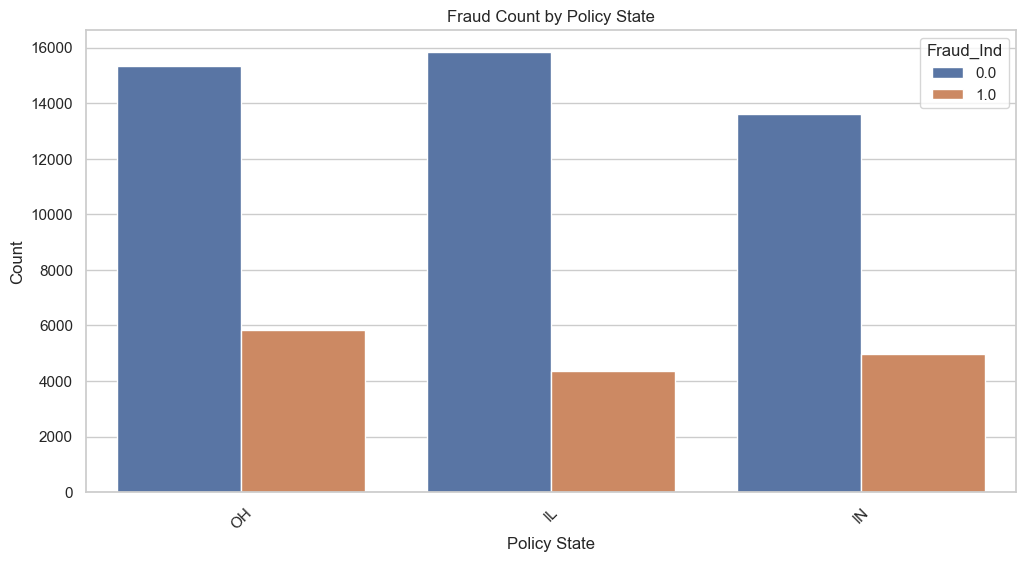

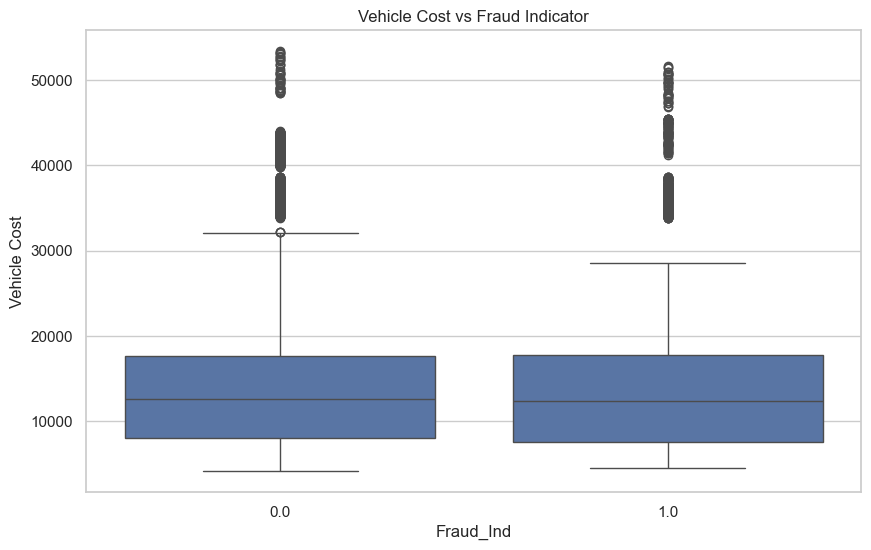

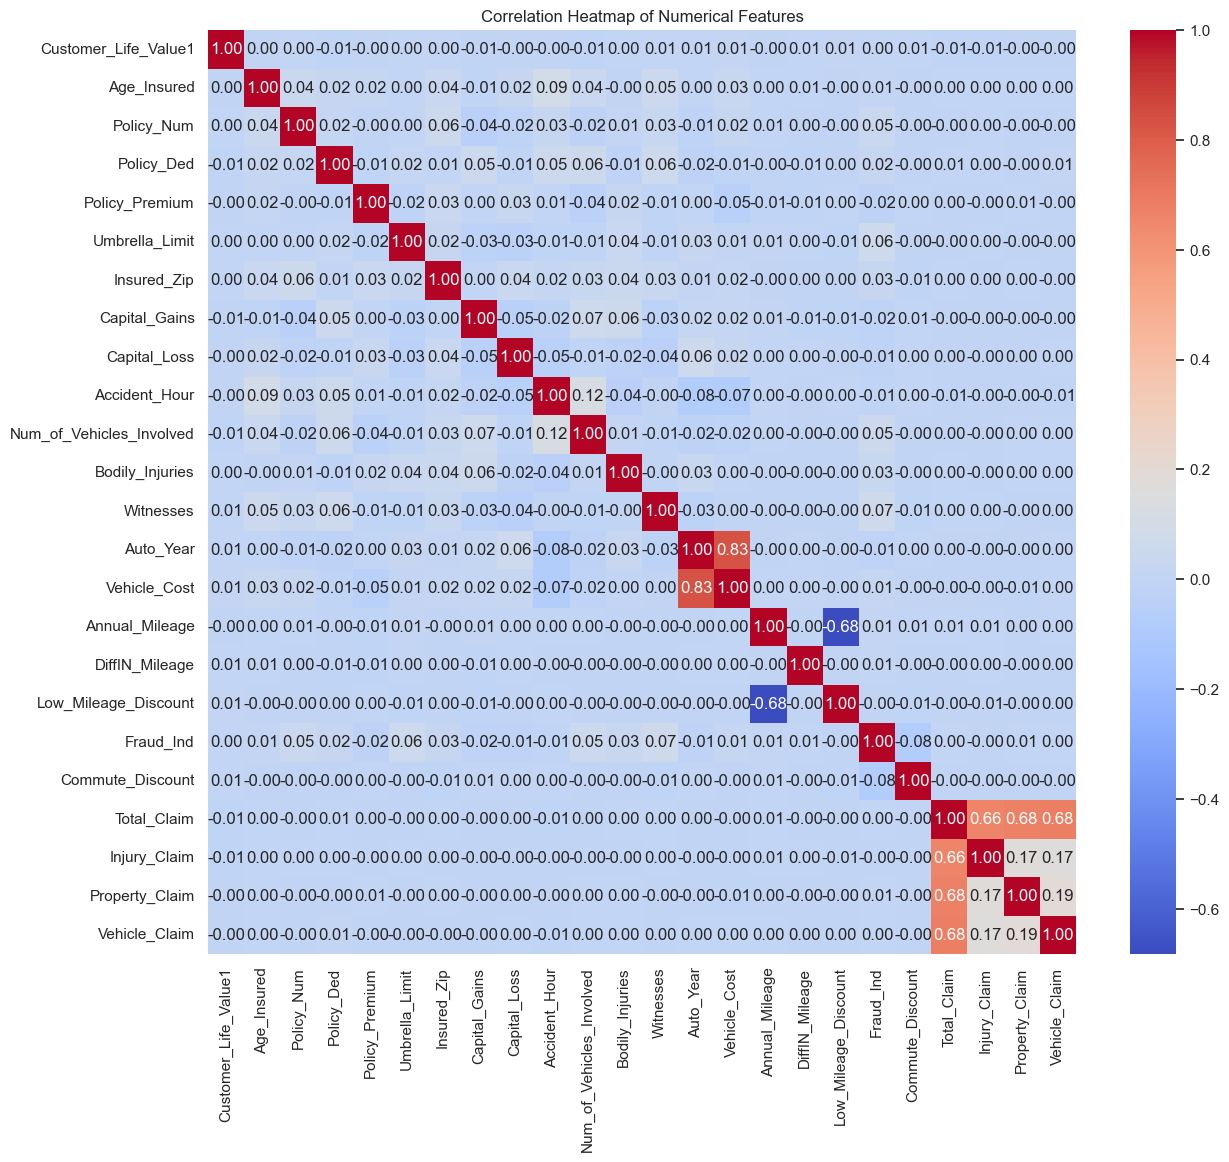

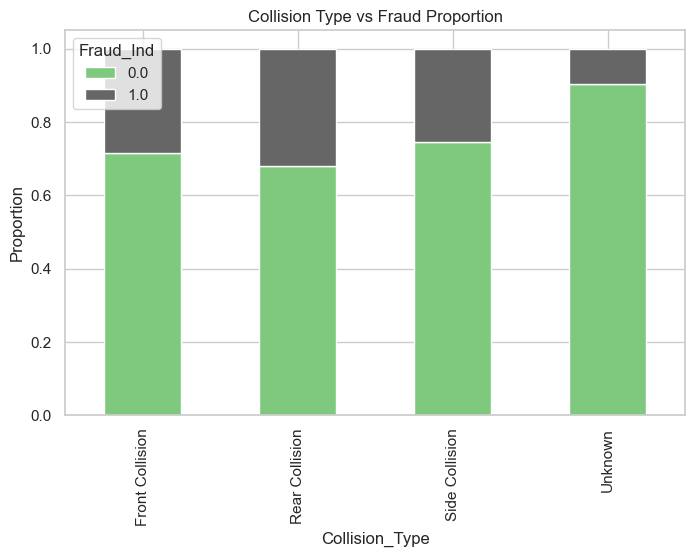

In [4]:
# ----------------------------------------
# 🔍 EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set(style="whitegrid")

# ✅ 1. Target Distribution (Fraud vs Non-Fraud)
plt.figure(figsize=(6,4))
sns.countplot(x='Fraud_Ind', data=df_all_cleaned)
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("Fraud_Ind (0 = No Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# ✅ 2. Age of Insured Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_all_cleaned['Age_Insured'], bins=30, kde=True, color='teal')
plt.title("Age Distribution of Insured")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# ✅ 3. Fraud Count by Policy State
plt.figure(figsize=(12,6))
sns.countplot(x='Policy_State', hue='Fraud_Ind', data=df_all_cleaned)
plt.title("Fraud Count by Policy State")
plt.xlabel("Policy State")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ✅ 4. Vehicle Cost vs Fraud
plt.figure(figsize=(10,6))
sns.boxplot(x='Fraud_Ind', y='Vehicle_Cost', data=df_all_cleaned)
plt.title("Vehicle Cost vs Fraud Indicator")
plt.xlabel("Fraud_Ind")
plt.ylabel("Vehicle Cost")
plt.show()

# ✅ 5. Heatmap of Correlation (Numerical Features Only)
plt.figure(figsize=(14,12))
numerical_data = df_all_cleaned.select_dtypes(include=['int64', 'float64'])
corr = numerical_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# ✅ 6. Pairplot (Optional - slow on large datasets)
# sns.pairplot(df_all_cleaned[['Total_Claim', 'Vehicle_Cost', 'Annual_Mileage', 'Age_Insured', 'Fraud_Ind']], hue='Fraud_Ind')

# ✅ 7. Cross-tab of Collision Type vs Fraud
if 'Collision_Type' in df_all_cleaned.columns:
    collision_fraud = pd.crosstab(df_all_cleaned['Collision_Type'], df_all_cleaned['Fraud_Ind'], normalize='index')
    collision_fraud.plot(kind='bar', stacked=True, figsize=(8,5), colormap="Accent")
    plt.title("Collision Type vs Fraud Proportion")
    plt.ylabel("Proportion")
    plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# ✅ Step 1: Feature Matrix and Target Variable
X = df_all_encoded.drop('Fraud_Ind', axis=1)
y = df_all_encoded['Fraud_Ind']

# ✅ Step 2: Fit Random Forest to Get Feature Importances
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# ✅ Step 3: Sort and Get Top 20 Features by Importance
importances = rf_model.feature_importances_
feature_names = X.columns
top_indices = np.argsort(importances)[-20:][::-1]  # Top 20 indices
top_features = feature_names[top_indices]          # Dynamic column names

print("✅ Top 20 Important Features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

# ✅ Step 4: Subset X based on top features
X_top = X[top_features]

# ✅ Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# ✅ Step 6: Ensure numeric format
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# ✅ Step 7: Apply SMOTE to handle imbalance
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# ✅ Step 8: Output distribution
print("\n✅ Class distribution before SMOTE:\n", y_train.value_counts())
print("✅ Class distribution after SMOTE:\n", y_train_smote.value_counts())


✅ Top 20 Important Features:
1. Accident_Severity_Minor Damage
2. Hobbies_chess
3. Accident_Severity_Total Loss
4. Policy_Num
5. Insured_Zip
6. Policy_Premium
7. Hobbies_cross-fit
8. Age_Insured
9. Accident_Hour
10. Vehicle_Cost
11. Capital_Gains
12. Auto_Year
13. Capital_Loss
14. Collision_Type_Unknown
15. Witnesses
16. Garage_Location_Yes
17. Umbrella_Limit
18. Property_Damage
19. Bodily_Injuries
20. Police_Report

✅ Class distribution before SMOTE:
 Fraud_Ind
0.0    35888
1.0    12112
Name: count, dtype: int64
✅ Class distribution after SMOTE:
 Fraud_Ind
1.0    35888
0.0    35888
Name: count, dtype: int64


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# ⚡ Step 1: Feature-Target Split
X = df_all_encoded.drop('Fraud_Ind', axis=1)
y = df_all_encoded['Fraud_Ind']

# ⚡ Step 2: Feature Selection (Top 20 using Mutual Info)
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
X_selected = X[selected_features]  # ✅ Avoid transformation for interpretability

# ⚡ Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y  # Stratify for class balance
)

# ⚡ Step 4: Convert types once
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# ⚡ Step 5: Apply SMOTE
sm = SMOTE(random_state=42, n_jobs=-1)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("✅ Class Distribution After SMOTE:\n", y_train_smote.value_counts())

# ⚡ Step 6: Train XGBoost with optimized params
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,        # Less trees for speed
    max_depth=5,             # Shallower trees = faster
    learning_rate=0.1,       # Decent default
    n_jobs=-1,               # Use all CPU cores
    verbosity=0              # Silent for speed
)
xgb_model.fit(X_train_smote, y_train_smote)

# ⚡ Step 7: Predict & Evaluate
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# ✅ Results
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("📈 ROC-AUC Score:", roc_auc_score(y_test, y_prob))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

# ⚙ Train Random Forest on same data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# 🔮 Predictions & Probabilities
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# 🧠 XGBoost predictions already done earlier
# y_pred_xgb, y_prob_xgb assumed from earlier step

# ⚖ F1 Score Comparison
f1_rf = f1_score(y_test, y_pred_rf)
f1_xgb = f1_score(y_test, y_pred_xgb)

# 📈 ROC-AUC Score Comparison
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# 📊 Print comparison results
print("🔍 F1-Score Comparison:")
print(f"Random Forest F1 Score: {f1_rf:.4f}")
print(f"XGBoost       F1 Score: {f1_xgb:.4f}")

print("\n📈 ROC-AUC Score Comparison:")
print(f"Random Forest ROC-AUC: {auc_rf:.4f}")
print(f"XGBoost       ROC-AUC: {auc_xgb:.4f}")


In [ ]:
import joblib

# ✅ Choose the better model based on ROC-AUC
best_model = xgb_model if auc_xgb > auc_rf else auc_rf

# ✅ Save model
joblib.dump(best_model, "best_fraud_model.pkl")

print("✅ Best model exported as 'best_fraud_model.pkl'")


In [ ]:
# Choose the best model based on earlier comparison
best_model = xgb_model if auc_xgb > auc_rf else rf_model

# Get only the selected feature names used for training
selected_features = X.columns[selector.get_support()]  # from earlier SelectKBest

# Extract feature importances
importances = best_model.feature_importances_

# Create DataFrame of top features
top_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

top_features_df = top_features_df.sort_values(by='Importance', ascending=False).head(10)

# Get top 10 features
top_10_features = top_features_df['Feature'].tolist()
print("✅ Top 10 Features:\n", top_10_features)


In [ ]:
# ✅ Convert only boolean columns to float
for df in [X_train, X_test]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)


In [ ]:
from imblearn.over_sampling import SMOTE

# ✅ Step 1: Ensure all features are numeric (bools converted to float)
for df in [X_train, X_test]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

# ✅ Step 2: Apply SMOTE only on training data
# Optionally, customize sampling_strategy if needed (e.g., 0.5 means minority will be 50% of majority)
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# ✅ Step 3: Print confirmation
print("✅ After SMOTE class distribution:\n", y_train_smote.value_counts())


In [ ]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# ✅ Step 1: Define feature matrix using top 10 features
X_top10 = df_all_encoded[top_10_features].copy()
y = df_all_encoded['Fraud_Ind'].copy()

# ✅ Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Step 3: Ensure SMOTE compatibility (convert bools to float)
for df in [X_train, X_test]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

# ✅ Step 4: Apply SMOTE to training set only
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# ✅ Step 5: Train XGBoost model
model_top10 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1  # Utilizes all cores
)
model_top10.fit(X_train_smote, y_train_smote)

# ✅ Step 6: Predict and evaluate
y_pred = model_top10.predict(X_test)
y_prob = model_top10.predict_proba(X_test)[:, 1]

# ✅ Step 7: Print evaluation metrics
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"🎯 Accuracy      : {accuracy_score(y_test, y_pred):.4f}")
print(f"📏 F1 Score      : {f1_score(y_test, y_pred):.4f}")
print(f"📈 ROC-AUC Score : {roc_auc_score(y_test, y_prob):.4f}")


In [ ]:
import joblib

# ✅ Save the trained XGBoost model
joblib.dump(model_top10, "fraud_model_top10.pkl")

# ✅ Original cleaned (pre-encoding) columns
original_columns = df_all_cleaned.columns.tolist()

# ✅ Map top encoded features to their true original columns
mapped_features = []
for feat in top_10_features:
    match = next((col for col in original_columns if feat == col or feat.startswith(col + "_")), None)
    if match:
        mapped_features.append(match)

# ✅ Remove duplicates while preserving order
from collections import OrderedDict
true_top10_features = list(OrderedDict.fromkeys(mapped_features))  # keeps order & removes duplicates

# ✅ Save true feature names
joblib.dump(true_top10_features, "top10_feature_list.pkl")

# ✅ Print output
print("✅ Model and TRUE top 10 feature list successfully saved.")
print("🔝 Top 10 features (original columns):")
for idx, feat in enumerate(true_top10_features, 1):
    print(f"  {idx}. {feat}")


In [ ]:
import joblib

# ✅ Load saved model and feature list
loaded_model = joblib.load("fraud_model_top10.pkl")
loaded_features = joblib.load("top10_feature_list.pkl")

# ✅ Print loaded features in a clean format
print("\n📂 Loaded Top 10 Feature List (Original Columns):")
for idx, feat in enumerate(loaded_features, 1):
    print(f"  {idx}. {feat}")

# ✅ Confirm model type
print("\n✅ Loaded Model Type:", type(loaded_model).__name__)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 🧩 Optional: sample if data is large (for faster plots)
sample_df = df_all_encoded.sample(n=min(2000, len(df_all_encoded)), random_state=42)

# ✅ 1. Class Distribution
plt.figure()
sns.countplot(x='Fraud_Ind', data=df_all_encoded, palette='Set2')
plt.title("1️⃣ Class Distribution (Fraud vs Non-Fraud)")
plt.tight_layout()
plt.show()

# ✅ 2. Correlation Heatmap of Top 10 Features + Target
plt.figure(figsize=(10, 8))
corr = df_all_encoded[top_10_features + ['Fraud_Ind']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("2️⃣ Correlation Heatmap")
plt.tight_layout()
plt.show()

# ✅ 3–7. Boxplots for Top 5 Features
for idx, col in enumerate(top_10_features[:5], 3):
    plt.figure()
    sns.boxplot(x='Fraud_Ind', y=col, data=df_all_encoded, palette='Set3')
    plt.title(f"{idx}️⃣ Boxplot: {col} by Fraud Indicator")
    plt.tight_layout()
    plt.show()

# ✅ 8–12. Distribution (Histogram + KDE) for Top 5 Features
for idx, col in enumerate(top_10_features[:5], 8):
    plt.figure()
    sns.histplot(data=df_all_encoded, x=col, hue='Fraud_Ind', bins=30, kde=True, palette='Set1', alpha=0.6)
    plt.title(f"{idx}️⃣ Distribution: {col}")
    plt.tight_layout()
    plt.show()

# ✅ 13. Pairplot of Top 4 Features + Target
sns.pairplot(sample_df[top_10_features[:4] + ['Fraud_Ind']], hue='Fraud_Ind', corner=True, palette='husl')
plt.suptitle("1️⃣3️⃣ Pairplot (Top 4 Features)", y=1.02)
plt.show()

# ✅ 14. Violin Plot for Most Important Feature
top_feat = top_10_features[0]
plt.figure()
sns.violinplot(x='Fraud_Ind', y=top_feat, data=df_all_encoded, palette='Set2')
plt.title(f"1️⃣4️⃣ Violin Plot: {top_feat} by Fraud Indicator")
plt.tight_layout()
plt.show()

# ✅ 15. Barplot of Mean Feature Values by Class
means = df_all_encoded.groupby('Fraud_Ind')[top_10_features].mean().T
means.columns = ['Legit', 'Fraud']
means.plot(kind='bar', figsize=(10, 6), colormap='Accent')
plt.title("1️⃣5️⃣ Mean Feature Values by Class (Top 10 Features)")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
